# RASER MRI Sim 5
> **Code Author**: Alon Greenbaum \
> **Last Edit**: 1 August 2025 \
> **Last Edited by**: Reagan McNeill Womack \

Code based on dynamics and theory outlined in [DOI: 10.1126/sciadv.abp8483](https://doi.org/10.1126/sciadv.abp8483)

*Google Gemini generative AI was used in the development of this notebook.*

## Requirements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pathlib import Path
import os
from datetime import datetime
import time as timenow
import random
from skimage.transform import radon, iradon
from skimage.io import imsave

## Results Directory
If directory does not exist, a new directory is made at location defined with `path`.

In [2]:
def makedirs(path):
  if not os.path.exists(path):
    os.makedirs(path)

## Sample Inversion Map
Create a sample 2D inversion map with a square shape for demonstration.

### Parameters
- `shape` (tuple of `int`, default: `(10,10)`: defines size of map, includes 2 variables (1 for each direction); represents the initial distribution of population inversion in a 2D space

### Returns
- A 2D NumPy array with dimensions specified by `shape`, a simplified population inversion map

In [3]:
def create_sample_inversion_map(shape=(10,10)):
  square_size = (shape[0] // 2, shape[1] // 2) # set size of square using parameter
  inversion_map = np.full(square_size, 1)
  inversion_map = np.pad(inversion_map, ((shape[0] // 4, shape[0] // 4), (shape[1] // 4, shape[1] // 4)), mode="constant", constant_values=0)
  return inversion_map

### Create 1D Inversion Map
For testing purposes ONLY \
Flattens 2D sample inversion map from above

In [4]:
def create_sample_inversion_map_flattened(shape=(10,10), angle=0, d0_total_val=25e16):
    sample_2d_map = create_sample_inversion_map(shape=shape) # create 2D map

    # get a 1D projection from 2D map at angle theta (default 0 deg)
    single_projection_1d = radon(sample_2d_map, theta=[angle], circle=True).flatten()

    # normalize (optional)
    if np.sum(single_projection_1d) > 0:
        single_projection_1d = single_projection_1d / np.sum(single_projection_1d)

    # scale by total population inversion (if applicable)
    scaled_single_projection = (d0_total_val * single_projection_1d)

    """
    # plot 1D inversion map
    plt.figure(figsize=(10,10))
    plt.plot(scaled_single_projection)
    plt.title(f'1D Projection from 2D Map (Angle = {angle} degrees)')
    plt.xlabel('Detector Element / Mode Index')
    plt.ylabel('Normalized Projection Value')
    plt.grid(True)
    plt.show()
    """

    return scaled_single_projection

## Simulate RASER Dynamics
Core simulation function \
It models the time evolution of multiple interacting RASER (Radio-frequency Amplification by Stimulated Emission of Radiation) modes based on a set of coupled non-linear ordinary differential equations (ODEs), as described in the supplementary material (equations S5-S9). It takes an initial 1D population inversion profile and simulates how the population inversion, mode amplitudes, and phases change over time, ultimately calculating the total measurable output signal.

### Parameters
- `initial_population_inversion` (numpy.ndarray): a 1D NumPy array representing the initial population inversion $d_{\mu}(0)$ for each RASER mode/slice; this array is typically a 1D projection obtained from the 2D image
- `T1` (float, default: 5.0): the longitudinal relaxation time $T_1$ in seconds; this parameter governs how quickly the population inversion recovers to its equilibrium state (or decays if no pumping is present)
- `T2` (float, default: 0.7): the effective transverse relation time $T_2^*$ in seconds; this parameter describes the decay of the transverse magnetization (and thus the amplitude for each mode)
- `coupling_beta` (float, default: 1.0): the coupling parameter $\beta$ that dictates the strength of the interaction between the RASER modes and the overall gain; it's derived from physical constant and resonator properties
- `center_freq_hz` (float, default: 50.0): the center frequency $\nu_0$ of the RASER resonator in Hertz; this is the central frequency around which the individual RASER modes are distributed
- `gain_bandwidth_hz` (float, default: 10.0): the total bandwidth $\Delta$ of the imaging domain in Hertz, which corresponds to the frequency range covered by the magnetic field gradient
- `mode_spacing_hz` (float, default: 0.2): the frequency separation $\delta \nu$ between adjacent RASER modes in Hertz
- `sim_duration` (float, default: 2.0): the total duration of the simulation in seconds
- `points_per_sec` (int, default: 2000): the number of data points to generate per second of simulation time for the output signal; this affects the temporal resolution of the `output_signal`

### Returns: `dict`
A dictionary containing the results of the simulation.
- `time` (numpy.ndarray): a 1D array of time points (in seconds) at which the output signal was sampled
- `n_modes` (int): the number of RASER modes/slices ($N$) simulated
- `initial_inversion` (numpy.ndarray): the 1D array of initial population inversion values for each mode, as provided to the function
- `final_inversion` (numpy.ndarray): a 1D array of the population inversion values for each mode at the end of the simulation
- `final_amplitude` (numpy.ndarray): a 1D array of the amplitude values ($A_\mu$) for each mode at the end of the simulation
- `output_signal` (numpy.ndarray): a 1D array representing the total simulated RASER signal ($Sig(t)$) (see Eq. S9) over the `sim_duration`

In [10]:
def simulate_raser_dynamics(
        initial_population_inversion,
        T1=5.0,
        T2=0.7,
        coupling_beta=1.0,
        center_freq_hz=50.0,
        gain_bandwidth_hz=10.0,
        mode_spacing_hz=0.2,
        sim_duration=10.0,
        points_per_sec=2000,
):
    N = len(initial_population_inversion)

    # prevent running the simulation on empty projections
    if N == 0 or np.all(initial_population_inversion == 0):
        print("Initial Population Inversion is an empty projection - simulation cancelled")
        return {
            'time': np.linspace(0, sim_duration, int(sim_duration * points_per_sec)),
            'n_modes': N,
            'initial_inversion': initial_population_inversion,
            'final_inversion': np.zeros(N),
            'final_amplitude': np.zeros(N),
            'output_signal': np.zeros(int(sim_duration * points_per_sec)),
        }

    print(f"Running multimode RASER simulation with {N} modes...")
    epsilon = 1e-12 # used to prevent division by zero
    mu_indices = np.arange(1, N + 1)
    natural_freq_hz = center_freq_hz - 0.5 * (gain_bandwidth_hz - mode_spacing_hz * (2 * mu_indices - 1))
    omega_natural_rad = 2 * np.pi * natural_freq_hz # first term in Eq. S7

    d0 = initial_population_inversion # initial population inversion for each mode
    A0 = np.random.uniform(0,1e-4,N) # initial amplitudes for each mode, set to tiny random values
    phi0 = np.random.uniform(0,2 * np.pi,N) # initial phases for each mode, set to random values between 0 and 2pi
    y0 = np.concatenate([d0,A0,phi0]) # create 1D array from above 3 arrays in format ODE solver expects

    def raser_ode_system(t, y):
        d = y[0:N]
        A = y[N:2 * N]
        phi = y[2 * N:3 * N]

        X = np.sum(A * np.cos(phi))
        Y = np.sum(A * np.sin(phi))
        cos_phi = np.cos(phi)
        sin_phi = np.sin(phi)
        sum_term_1 = (X * cos_phi) + (Y * sin_phi)
        sum_term_2 = (Y * cos_phi) - (X * sin_phi)

        S5 = -(d/T1)-(4*coupling_beta*d*(sum_term_1 ** 2)) # solves Eq. S5, population inversions
        S6 = -(A/T2) + (coupling_beta * d * sum_term_1) # solves Eq. S6, transverse amplitudes
        S7 = omega_natural_rad + (coupling_beta * (d / (A + epsilon))) * sum_term_2 # solves Eq. S7, transverse phases

        dydt = np.concatenate([S5, S6, S7]) # concatenates functions into a 1D array matching structure of y
        return dydt

    t_span = [0, sim_duration] # defines time interval from 0 to sim_duration
    """
    Solve ODEs (ordinary differential equations)
    dense_output = True creates a continuous solution object that can be evaluated at arbitrary time points
    """
    sol = solve_ivp(raser_ode_system, t_span, y0, method='BDF', dense_output=True)

    """
    Process Output Signal
    """
    output_t_points = np.linspace(t_span[0], t_span[1], int(sim_duration * points_per_sec)) # array of time points created using sim_duration and points_per_sec
    output_signal = np.zeros(len(output_t_points))
    final_state_y = sol.sol(output_t_points[-1]) # all d, A, and phi values at last outputTimePoint

    for i, t_point in enumerate(output_t_points): # Signal Calculation Loop
        current_state_y = sol.sol(t_point) # used to retrieve d, A, and phi at current t_point
        A_current = current_state_y[N:2*N] # amplitudes at current_state_y
        phi_current = current_state_y[2*N:3*N] # phases at current_state_y
        output_signal[i] = (1 / np.sqrt(N)) * np.sum(A_current * np.cos(phi_current)) # total RASER signal calculated from Eq. S9

    return {
        'time': output_t_points,
        'n_modes': N,
        'initial_inversion': d0,
        'final_inversion': final_state_y[0:N],
        'final_amplitude': final_state_y[N:2*N],
        'output_signal': output_signal,
    }

## Plot Results
Visualizes the simulation results from the multimode RASER model

### Parameters
- `results` (*dict*): A dictionary containing the output from the simulate_raser_dynamics function. It is expected to have the following keys:
    - `time` (numpy.ndarray): a 1D array of time points (in seconds) at which the output signal was sampled
    - `n_modes` (int): the number of RASER modes/slices ($N$) simulated
    - `initial_inversion` (numpy.ndarray): the 1D array of initial population inversion values for each mode, as provided to the function
    - `final_inversion` (numpy.ndarray): a 1D array of the population inversion values for each mode at the end of the simulation
    - `final_amplitude` (numpy.ndarray): a 1D array of the amplitude values ($A_\mu$) for each mode at the end of the simulation
    - `output_signal` (numpy.ndarray): a 1D array representing the total simulated RASER signal ($Sig(t)$) (see Eq. S9) over the `sim_duration`
- `png_path` (*pathlib.Path object*): the full file path (including filename and .png extension) where the generated plot will be saved

### Outputs
- saves a`.png` image file to the specified `png_path`
- displays plot using `plt.show()` and closes plot with `plt.close(fig)` to free up memory

In [6]:
def plot_results(results, png_path):
    time = results['time']
    N = results['n_modes']
    signal = results['output_signal']
    mode_indices = np.arange(1, N + 1) if N > 0 else [] # mu index for plotting

    fig, axes = plt.subplots(2, 2, figsize=(14, 11)) # creates a figure with a 2x2 grid for 4 plots
    fig.suptitle("Multimode RASER Simulation (Single Projection)", fontsize=16)

    # Subplot 1. Population Inversion Profiles (top-left)
    ax1 = axes[0, 0] # select top-left subplot
    if N > 0: # plot two lines if N > 0
        ax1.plot(mode_indices, results['initial_inversion'], 'o-', label=f'$d_\\mu(t=0)$')
        ax1.plot(mode_indices, results['final_inversion'], 'o-', label=f'$d_\\mu(t={time[-1]:.2f}s)$')
    ax1.set_title("Population Inversion Profiles")
    ax1.set_xlabel("Mode Index ($\\mu$)")
    ax1.set_ylabel("Population Inversion ($d_\\mu$)")
    ax1.legend()
    ax1.grid(True)

    # Subplot 2. Final Mode Amplitudes (top-right)
    ax2 = axes[0, 1] # select top-right subplot
    if N > 0:
        ax2.bar(mode_indices, results['final_amplitude'], width=0.8)
    ax2.set_title(f"Final Mode Amplitudes ($A_\\mu$) at t={time[-1]:.2f}s")
    ax2.set_xlabel("Mode Index ($\\mu$)")
    ax2.set_ylabel("Amplitude ($A_\\mu$)")
    ax2.grid(True, axis='y')

    # Subplot 3. Total Output Signal (bottom-left)
    ax3 = axes[1, 0] # select bottom-left subplot
    ax3.plot(time, signal)
    ax3.set_title("Total Output Signal $Sig(t)$ (Eq. S9)")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Signal Amplitude (a.u.)")
    ax3.grid(True)

    # Subplot 4. Spectrum of Output Signal (bottom-right)
    min_freq_hz = 35
    max_freq_hz = 65
    ax4 = axes[1, 1] # select bottom-right subplot
    dt = time[1] - time[0]
    signal_fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal_fft), d=dt)
    shifted_freqs = np.fft.fftshift(freqs)
    shifted_magnitudes = np.fft.fftshift(np.abs(signal_fft))
    freq_mask = (shifted_freqs >= min_freq_hz) & (shifted_freqs <= max_freq_hz)
    ax4.plot(shifted_freqs[freq_mask], shifted_magnitudes[freq_mask])
    ax4.set_title("Spectrum of Output Signal")
    ax4.set_xlabel("Frequency (Hz)")
    ax4.set_ylabel("Magnitude")
    ax4.grid(True)

    # Finalize and save figure
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(png_path)
    plt.show()
    print(f"Saved results as PNG to {png_path}")
    plt.close(fig)


## Plot Reconstruction Comparison
Provides a direct visual comparison between the initial 2D image and the image reconstructed from the RASER signals

### Parameters
- `original_image` (*numpy.ndarray*): 2D NumPy array representing initial image (i.e. `initial_map` created by `create_sample_inversion_map`); reference image for comparison
- `reconstructed_image` (*numpy.ndarray*): 2D NumPy array representing imaged reconstructed from simulated RASER signals using inverse Radon transform
- `path` (*pathlib.Path object*): full file path (including extension) where the generated comparison plot will be saved

### Outputs
- saves a `.png` image to the specified `path`
- displays plot using `plt.show()` and closes plot with `plt.close(fig)`

In [7]:
def plot_reconstruction_comparison(original_image, reconstructed_image, path):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # create figure and 1x2 grid of axes objects
    fig.suptitle("Image Reconstruction Comparison", fontsize=16)

    # Subplot 1. Original Image (left)
    orig = axes[0]
    orig.imshow(original_image, cmap='gray', vmin=0, vmax=1)
    orig.set_title("Original Image")
    orig.set_axis_off()

    # Subplot 2. Reconstructed Image (right)
    recon = axes[1]
    recon.imshow(reconstructed_image, cmap='gray')
    recon.set_title("Reconstructed from RASER Signals")
    recon.set_axis_off()

    # Finalizing and Saving
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(path)
    plt.show()
    print(f"Saved reconstruction comparison to {path}")
    plt.close(fig)

## Main Execution Block
- Defines all constants and parameters for the simulation
- Sets up directory structure for saving results
- Executes simulations
- Saves results
- Generates plots

### Physical Constants and Experimental Parameters
*from paper* indicates value listed in function was taken from reference material linked at the top of this document
- `mu_0`: vacuum permeability $\mu_0$
- `h_bar`: reduced Planck constant $\hbar$
- `gamma_h`: proton ($^{1}H$) gyromagnetic ratio $\gamma_H$
- `T1`: longitudinal relaxation time $T_1$ *from paper*
- `T2`: effective transverse relaxation time $T_2$ *from paper*
- `q_factor`: quality factor of the resonator $Q$ *from paper*
- `v_s`: sample volume $V_s$ *from paper*
- `n_modes`: conceptual number of slices or modes; determines resolution of the 2D phantom
- `delta_nu`: frequency spacing between modes $\delta_{\nu}$ *from paper*
- `Delta`: total gain bandwidth $\Delta$ *from paper*
- `nu_0`: center frequency $\nu_0$ *from paper*
- `d0_total`: total initial population inversion of entire sample; used to scale 1D projections
- `cplng_beta_calc`: coupling parameter $\beta$ is calculated from above physical constants before being passed to simulate_laser_dynamics function

### Reconstruction Parameters
- `n_proj`: number of angles at which projections of 2D image will be taken; more projections lead to better reconstruction quality but increase computation time
- `min_freq_hz` & `max_freq_hz`: define frequency window of interest when processing FFT of RASER output signal; only signal components within this range are considered for reconstructing the 1D projection

### Setup Angles and Initialize Sinogram
- `theta`: array of angles (in degrees) from 0 to just under 180, equally spaced by `n_proj`; angles at which the 2D image will be projected
- `placehold_proj`: dummy Radon transform is performed at 0 deg to determine `detector_len`; use `radon` to get the expected detector size for the sinogram, `circle=True` ensures the projection size is consistent for reconstruction
- `detector_len`: length of a single 1D projection (i.e. "number of detector elements" in each projection)
- `reconstructed_sinogram`: empty 2D NumPy array initialized with zeros; will store all 1D *reconstructed* projections, with each column corresponding to a projection at a specific angle; primary input for the inverse Radon transform

Calculated Coupling Constant beta: 9.4843e-15

Results will be saved at: Sim_RASER_Output\RASER_reconstruction_2025-0801_153356

Simulation log created

Reconstruction Parameters Set
Number of Projections: 60
Frequency Range: 35-65
Original 2D Ground Truth Image Created

Starting reconstruction with 60 projections...
Each reconstructed projection will be interpolated to a detector length of 49.

--- Processing Projection 1/60 (Angle: 0.0 deg) ---
...Obtained 1D projection for current angle
...Projection prepared for simulation
Running multimode RASER simulation with 49 modes...
RASER simulation complete for current angle
...FFT performed on simulation output
1D Projection reconstructed from simulation
...filtered_mag resized to match detector_len
Reconstructed projection stored in sinogram

--- Processing Projection 2/60 (Angle: 3.0 deg) ---
...Obtained 1D projection for current angle
...Projection prepared for simulation
Running multimode RASER simulation with 49 modes...
RASER simula

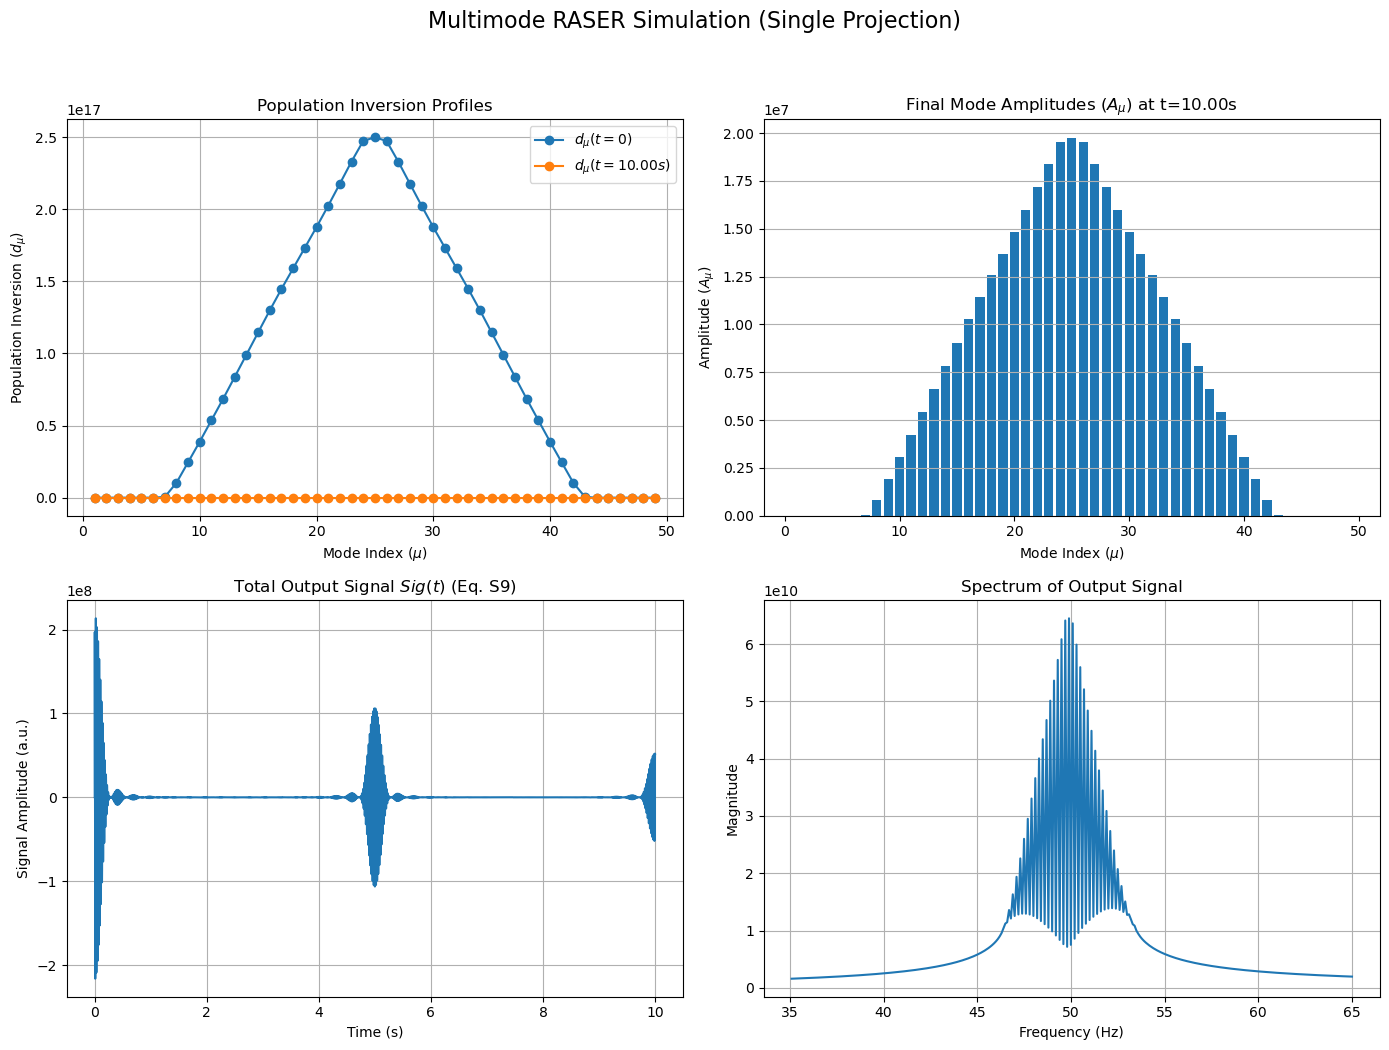

Saved results as PNG to Sim_RASER_Output\RASER_reconstruction_2025-0801_153356\Figure1_Single_Projection_Analysis.png
Figure 1 saved to Sim_RASER_Output\RASER_reconstruction_2025-0801_153356/Figure1_Single_Projection_Analysis.png

Generating Figure 2. Original vs. Reconstructed Image...


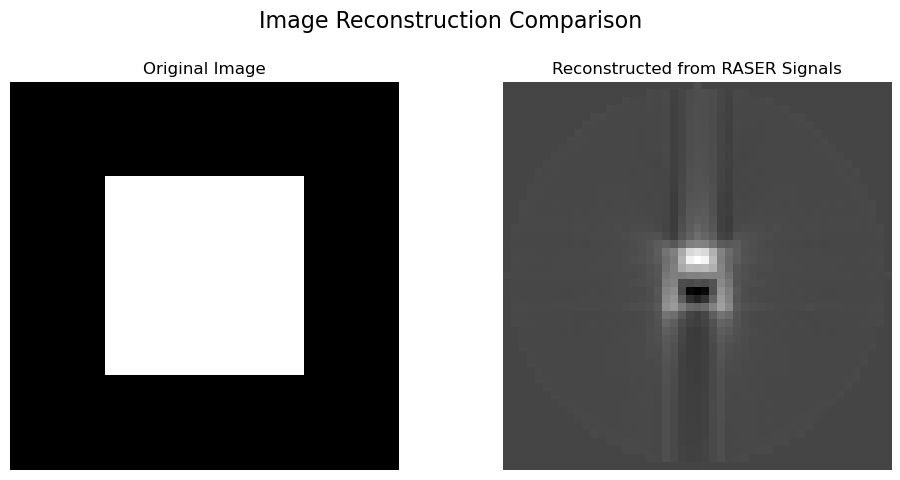

Saved reconstruction comparison to Sim_RASER_Output\RASER_reconstruction_2025-0801_153356\Figure2_Reconstruction_Comparison.png
Figure 2 saved to Sim_RASER_Output\RASER_reconstruction_2025-0801_153356/Figure2_Reconstruction_Comparison.png

--- SIMULATION COMPLETE ---
Physical Constants & Experimental Parameters

    mu_0: 1.2566370614359173e-06
    h_bar: 1.05457e-34
    gamma_h: 267522000.0
    T1: 50.0
    T2: 7.0
    q_factor: 2000
    v_s: 5.000000000000001e-07
    n_modes: 50
    delta_nu: 0.2
    Delta: 10.0
    nu_0: 50.0
    d0_total: 2.5e+17
    cplng_beta_calc: 9.48427813746681e-15
    
Time Elapsed: 21.14 seconds (0.35 minutes)


In [11]:
if __name__ == '__main__':
    # Record start time
    start_time = timenow.time()

    # --- Physical Constants and Experimental Parameters ---
    mu_0 = 4 * np.pi * 1e-7
    h_bar = 1.05457e-34
    gamma_h = 2.67522e8
    T1 = 5.0 * 10
    T2 = 0.7 * 10
    q_factor = 2000
    v_s = 0.5 * (1e-2)**3
    n_modes = 50
    delta_nu = 0.2
    Delta = 10.0
    nu_0 = 50.0
    d0_total = 25e16
    cplng_beta_calc = (mu_0 * h_bar * gamma_h**2 * q_factor) / (4 * v_s)
    print(f'Calculated Coupling Constant beta: {cplng_beta_calc:.4e}\n')

    # Setup Output Directory
    output_directory_root = Path('./Sim_RASER_Output/') # root folder for outputs, using local directory
    model_name = '{}_{}'.format('RASER_reconstruction', datetime.now().strftime("%Y-%m%d_%H%M%S")) # unique name for current run with timestamp
    results_dir = output_directory_root / model_name # full path for current run results
    makedirs(results_dir)
    print(f'Results will be saved at: {results_dir}\n')

    # create log file with important information
    with open(f'{results_dir}/simulation_log.txt', 'w') as log:
        log.write(f'~~~~~~ SIMULATION LOG FOR {results_dir} ~~~~~~\n')
        log.write('\n')
        log.write('--- Physical Constants and Experimental Parameters ---\n')
        log.write(f'mu_0: {mu_0}\n')
        log.write(f'h_bar: {h_bar}\n')
        log.write(f'gamma_h: {gamma_h}\n')
        log.write(f'T1: {T1}\n')
        log.write(f'T2: {T2}\n')
        log.write(f'q_factor: {q_factor}\n')
        log.write(f'v_s: {v_s}\n')
        log.write(f'n_modes: {n_modes}\n')
        log.write(f'delta_nu: {delta_nu}\n')
        log.write(f'Delta: {Delta}\n')
        log.write(f'nu_0: {nu_0}\n')
        log.write(f'd0_total: {d0_total}\n')
        log.write(f'cplng_beta_calc: {cplng_beta_calc}\n')
        log.write('\n')
    print('Simulation log created\n')
    log.close()

    # --- Reconstruction Parameters ---
    n_proj = 60
    min_freq_hz = 35
    max_freq_hz = 65
    print('Reconstruction Parameters Set')
    print(f'Number of Projections: {n_proj}')
    print(f'Frequency Range: {min_freq_hz}-{max_freq_hz}')
    with open(f'{results_dir}/simulation_log.txt', 'a') as log:
        log.write(f'Number of Projections: {n_proj}\n')
        log.write(f'Frequency Range: {min_freq_hz}-{max_freq_hz}\n')
    log.close()

    # Create original 2D image
    init_map = create_sample_inversion_map(shape=(n_modes,n_modes)) # shape determined by n_modes
    print('Original 2D Ground Truth Image Created\n')

    # --- Setup angles and initialize sinogram ---
    theta = np.linspace(0., 180., n_proj, endpoint=False)
    placehold_proj = radon(init_map, theta=[0], circle=True)
    detector_len = len(placehold_proj)
    reconstructed_sinogram = np.zeros((detector_len, n_proj))
    print(f'Starting reconstruction with {n_proj} projections...')
    print(f'Each reconstructed projection will be interpolated to a detector length of {detector_len}.\n')
    with open(f'{results_dir}/simulation_log.txt', 'a') as log:
        log.write(f'theta: {theta}\n')
    log.close()

    # --- Main Tomography Loop ---
    for i, angle in enumerate(theta): # iterate through each angle defined in theta
        print(f'--- Processing Projection {i+1}/{n_proj} (Angle: {angle:.1f} deg) ---')

        # Radon transform to get 1D projection for current angle
        projection = radon(init_map, theta=[angle], circle=True).flatten()
        print('...Obtained 1D projection for current angle')

        # Prepare projection for simulation input
        if np.max(projection) > 0:
            projection = projection / np.sum(projection) # normalize
        init_pop_inv = d0_total * projection # convert projection to population inversion
        print('...Projection prepared for simulation')

        # Run RASER simulation
        sim_results = simulate_raser_dynamics(
            initial_population_inversion=init_pop_inv,
            T1=T1,
            T2=T2,
            coupling_beta=cplng_beta_calc,
            center_freq_hz=nu_0,
            gain_bandwidth_hz=Delta,
            mode_spacing_hz=delta_nu,
            sim_duration=10.0,
            points_per_sec=2000
        )
        print(f'RASER simulation complete for current angle')

        # FFT Output Signal
        signal = sim_results['output_signal']
        time = sim_results['time']
        dt = time[1] - time[0]
        signal_fft = np.fft.fft(signal) # perform Fast Fourier Transform (FFT) on output_signal
        freqs = np.fft.fftfreq(len(signal_fft), d=dt) # corresponding frequencies for FFT output
        print('...FFT performed on simulation output')
        shift_freq = np.fft.fftshift(freqs) # shift zero-frequency component to center
        shift_mag = np.fft.fftshift(np.abs(signal_fft)) # magnitude of complex FFT output
        freq_mask = (shift_freq >= min_freq_hz) & (shift_freq <= max_freq_hz) # only include frequencies within range
        filtered_mag = shift_mag[freq_mask] # only include magnitudes in frequency range
        print('1D Projection reconstructed from simulation')

        # Resized filtered_mag to match detector_len
        if len(filtered_mag) > 1:
            x_source = np.linspace(0, 1, len(filtered_mag))
            x_target = np.linspace(0, 1, detector_len)
            recon_proj_1d = np.interp(x_target, x_source, filtered_mag)
            print('...filtered_mag resized to match detector_len')
        else:
            recon_proj_1d = np.zeros(detector_len)
            ('...filtered_mag matches detector_len')

        # Store result in sinogram
        reconstructed_sinogram[:, i] = recon_proj_1d
        print('Reconstructed projection stored in sinogram\n')

    print('--- ALL PROJECTIONS PROCESSED ---')

    # Reconstruct 2D image with Inverse Radon Transform
    recon_img = iradon(reconstructed_sinogram, theta=theta, filter_name='ramp', circle=True)
    print('...2D image reconstructed')

    # Save artifacts
    np.save(results_dir / 'initial_2d_map.npy', init_map)
    np.save(results_dir / 'reconstructed_sinogram.npy', reconstructed_sinogram)
    np.save(results_dir / 'reconstructed_image.npy', recon_img)
    print(f'Key arrays saved as .npy at {results_dir}')

    # Normalize & save reconstructed image as .png
    recon_img_norm = (recon_img - np.min(recon_img)) / (np.max(recon_img) - np.min(recon_img))
    imsave(results_dir / 'reconstructed_image.png', (recon_img_norm * 255).astype(np.uint8))
    print(f'Reconstructed image saved as .png at {results_dir}\n')

    # Figure 1. Plot Random Projection
    print('Generating Figure 1. Detailed analysis for a single random projection...')
    rand_index = random.randint(0, n_proj - 1)
    rand_angle = theta[rand_index]
    print(f'...Selected random angle for Figure 1: {rand_angle:.1f}°')
    with open(f'{results_dir}/simulation_log.txt', 'a') as log:
        log.write('\n')
        log.write(f'Random Angle for Figure 1: {rand_angle:.1f}°\n')
    log.close()

    # 1D projection for random angle, normalize and scale
    rand_proj = radon(init_map, theta=[rand_angle], circle=True).flatten()
    if np.max(rand_proj) > 0:
        rand_proj /= np.max(rand_proj)
    init_pop_inv_rand = d0_total * rand_proj
    print('...1D projection for random angle prepared')

    single_run_results = simulate_raser_dynamics(
        initial_population_inversion=init_pop_inv_rand,
        T1=T1,
        T2=T2,
        coupling_beta=cplng_beta_calc,
        center_freq_hz=nu_0,
        gain_bandwidth_hz=Delta,
        mode_spacing_hz=delta_nu,
        sim_duration=10.0,
        points_per_sec=2000
    )
    print(f'--- RASER Dynamics Simulated for angle: {rand_angle:.1f}deg ---')
    plot_results(single_run_results, results_dir / 'Figure1_Single_Projection_Analysis.png')
    print(f'Figure 1 saved to {results_dir}/Figure1_Single_Projection_Analysis.png\n')

    # Figure 2. Original vs. Reconstructed Image
    print("Generating Figure 2. Original vs. Reconstructed Image...")
    plot_reconstruction_comparison(init_map, recon_img, results_dir / 'Figure2_Reconstruction_Comparison.png')
    print(f'Figure 2 saved to {results_dir}/Figure2_Reconstruction_Comparison.png\n')

    print('--- SIMULATION COMPLETE ---')
    print('Physical Constants & Experimental Parameters')
    print(f"""
    mu_0: {mu_0}
    h_bar: {h_bar}
    gamma_h: {gamma_h}
    T1: {T1}
    T2: {T2}
    q_factor: {q_factor}
    v_s: {v_s}
    n_modes: {n_modes}
    delta_nu: {delta_nu}
    Delta: {Delta}
    nu_0: {nu_0}
    d0_total: {d0_total}
    cplng_beta_calc: {cplng_beta_calc}
    """)

    # Record end time and calculate time elapsed
    end_time = timenow.time()
    elapsed_seconds = end_time - start_time
    elapsed_minutes = elapsed_seconds / 60

    # add time elapsed to simulation_log.txt
    with open(f'{results_dir}/simulation_log.txt', 'a') as log:
        log.write('\n--- SIMULATION DURATION ---\n')
        log.write(f'Simulation Started: {start_time}\n')
        log.write(f'Simulation Ended: {end_time}\n')
        log.write(f'Time Elapsed: {elapsed_seconds:.2f} seconds ({elapsed_minutes:.2f} minutes)')

    print(f'Time Elapsed: {elapsed_seconds:.2f} seconds ({elapsed_minutes:.2f} minutes)')

## Test Functions
Comment/uncomment out functions to test they are working.

In [76]:
# Sample Inversion map
# create_sample_inversion_map()

# 1D Sample Inversion map
# create_sample_inversion_map_flattened()

# Simulate RASER Dynamics
# simulate_raser_dynamics(initial_population_inversion=create_sample_inversion_map_flattened())

# Calculate Coupling Beta
'''
mu_0 = 4 * np.pi * 1e-7
h_bar = 1.05457e-34
gamma_h = 2.67522e8
T1 = 5.0
T2 = 0.7
q_factor = 100
v_s = 0.5 * (1e-2)**3
n_modes = 50
delta_nu = 0.2
Delta = 10.0
nu_0 = 50.0
d0_total = 25e16
cplng_beta_calc = (mu_0 * h_bar * gamma_h**2 * q_factor) / (4 * v_s)
print(f"""
mu_0: {mu_0}
h_bar: {h_bar}
gamma_h: {gamma_h}
T1: {T1}
T2: {T2}
q_factor: {q_factor}
v_s: {v_s}
n_modes: {n_modes}
delta_nu: {delta_nu}
Delta: {Delta}
nu_0: {nu_0}
d0_total: {d0_total}
cplng_beta_calc: {cplng_beta_calc}
""")
'''

# print(f'Time Elapsed: {elapsed_seconds:.2f} seconds ({elapsed_minutes:.2f} minutes)')

'\nmu_0 = 4 * np.pi * 1e-7\nh_bar = 1.05457e-34\ngamma_h = 2.67522e8\nT1 = 5.0\nT2 = 0.7\nq_factor = 100\nv_s = 0.5 * (1e-2)**3\nn_modes = 50\ndelta_nu = 0.2\nDelta = 10.0\nnu_0 = 50.0\nd0_total = 25e16\ncplng_beta_calc = (mu_0 * h_bar * gamma_h**2 * q_factor) / (4 * v_s)\nprint(f"""\nmu_0: {mu_0}\nh_bar: {h_bar}\ngamma_h: {gamma_h}\nT1: {T1}\nT2: {T2}\nq_factor: {q_factor}\nv_s: {v_s}\nn_modes: {n_modes}\ndelta_nu: {delta_nu}\nDelta: {Delta}\nnu_0: {nu_0}\nd0_total: {d0_total}\ncplng_beta_calc: {cplng_beta_calc}\n""")\n'